# Fitness Recommender System Using Natural Language Processing
## By: Landon Bragg and Ben Kim


## Intro
In personalized fitness, one of the main challenges is finding exercise routines that match individual preferences. This notebook focuses on building a fitness recommender system that uses natural language processing (NLP) techniques, specifically BERT (Bidirectional Encoder Representations from Transformers), to offer personalized exercise suggestions. The system takes user inputs—such as fitness level, target body part, and exercise type—to recommend exercises from a set of options. By converting both the exercise details and user preferences into vectors, it ranks exercises based on how closely they match the user's criteria. The system also includes a filtering feature to give higher priority to exercises that use the user’s preferred equipment. This research explores how well the BERT-based model can align recommendations with user preferences and how it handles the prioritization of exercises with specific equipment.









## Research Question
How can personalized workout recommendations based on a gym-goer’s experience level and fitness goals enhance adherence to regular exercise and improve long-term fitness outcomes? Are the recommendations useful and diverse enough to be useful to anyone, from a frequent gym-goer to a newbie?

In [18]:
# Import necessary libraries
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import torch

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/Gym.csv')

In [21]:
print(df.head())

   Unnamed: 0                         Title  \
0           0        Partner plank band row   
1           1  Banded crunch isometric hold   
2           2         FYR Banded Plank Jack   
3           3                 Banded crunch   
4           4                        Crunch   

                                                Desc      Type    BodyPart  \
0  The partner plank band row is an abdominal exe...  Strength  Abdominals   
1  The banded crunch isometric hold is an exercis...  Strength  Abdominals   
2  The banded plank jack is a variation on the pl...  Strength  Abdominals   
3  The banded crunch is an exercise targeting the...  Strength  Abdominals   
4  The crunch is a popular core exercise targetin...  Strength  Abdominals   

  Equipment         Level  Rating RatingDesc  
0     Bands  Intermediate     0.0        NaN  
1     Bands  Intermediate     NaN        NaN  
2     Bands  Intermediate     NaN        NaN  
3     Bands  Intermediate     NaN        NaN  
4     Bands  

In [22]:
# Removing the first and last columns because they are not useful
# Replacing Blank Descriptions and Ratings with values to prevent complications down the line
df.fillna({'Desc': "No Description"}, inplace=True)
df.fillna({'Rating': 0.0}, inplace=True)
df = df.iloc[:, 1:-1]
print(df.head())

                          Title  \
0        Partner plank band row   
1  Banded crunch isometric hold   
2         FYR Banded Plank Jack   
3                 Banded crunch   
4                        Crunch   

                                                Desc      Type    BodyPart  \
0  The partner plank band row is an abdominal exe...  Strength  Abdominals   
1  The banded crunch isometric hold is an exercis...  Strength  Abdominals   
2  The banded plank jack is a variation on the pl...  Strength  Abdominals   
3  The banded crunch is an exercise targeting the...  Strength  Abdominals   
4  The crunch is a popular core exercise targetin...  Strength  Abdominals   

  Equipment         Level  Rating  
0     Bands  Intermediate     0.0  
1     Bands  Intermediate     0.0  
2     Bands  Intermediate     0.0  
3     Bands  Intermediate     0.0  
4     Bands  Intermediate     0.0  


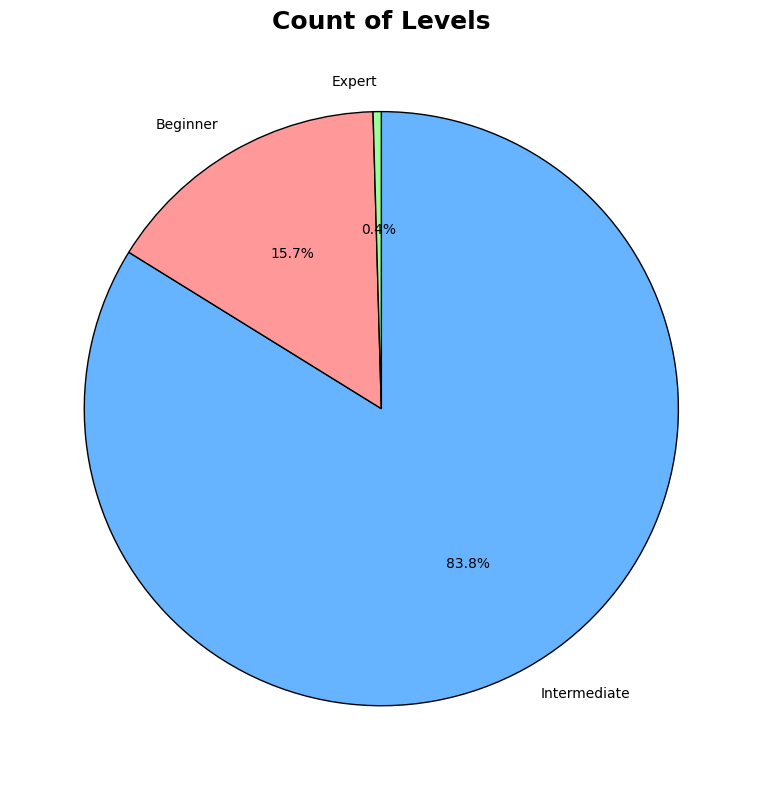

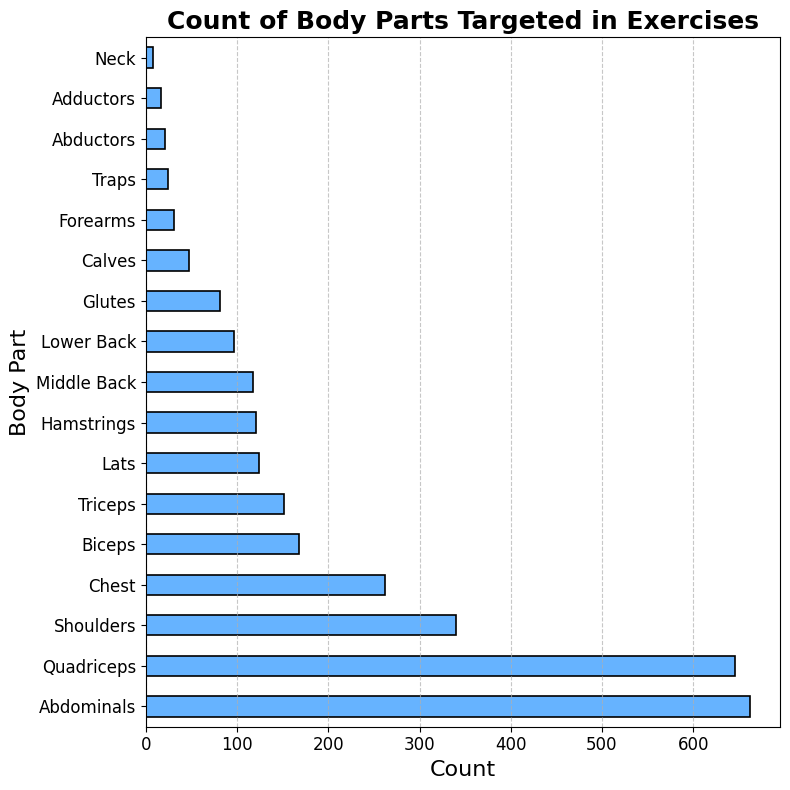

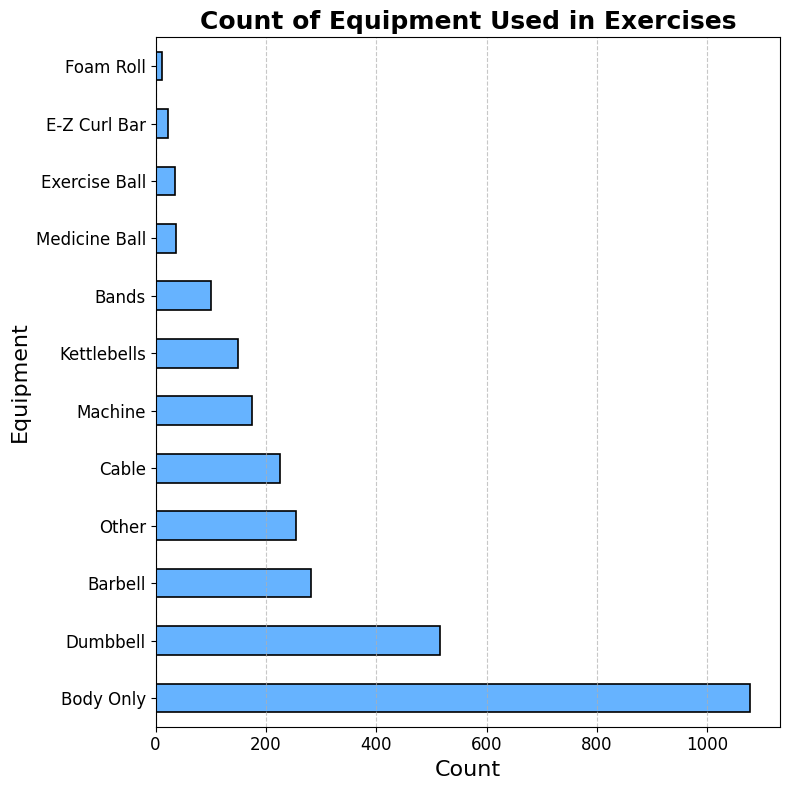

In [23]:
import matplotlib.pyplot as plt

# Common settings so all of the plots look uniform
figsize = (8, 8)
bar_color = '#66B3FF'
edge_color = 'black'
linewidth = 1.2
title_fontsize = 18
label_fontsize = 16
tick_fontsize = 12
grid_style = {'axis': 'x', 'linestyle': '--', 'alpha': 0.7}
colors = ['#66B3FF', '#FF9999', '#99FF99', '#FFCC99']

# Pie chart for "Count of Levels"
plt.figure(figsize=figsize)
level_counts = df['Level'].value_counts()
level_counts.plot.pie(
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Count of Levels', fontsize=title_fontsize, fontweight='bold')
plt.ylabel('')
plt.tight_layout()
plt.show()

# Bar chart for "Count of Body Parts Targeted"
plt.figure(figsize=figsize)
bodypart_counts = df['BodyPart'].value_counts()
bodypart_counts.plot.barh(
    color=bar_color,
    edgecolor=edge_color,
    linewidth=linewidth
)
plt.title('Count of Body Parts Targeted in Exercises', fontsize=title_fontsize, fontweight='bold')
plt.xlabel('Count', fontsize=label_fontsize)
plt.ylabel('Body Part', fontsize=label_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(**grid_style)
plt.tight_layout()
plt.show()

# Bar chart for "Count of Equipment Used"
plt.figure(figsize=figsize)
equipment_counts = df['Equipment'].value_counts()
equipment_counts.plot.barh(
    color=bar_color,
    edgecolor=edge_color,
    linewidth=linewidth
)
plt.title('Count of Equipment Used in Exercises', fontsize=title_fontsize, fontweight='bold')
plt.xlabel('Count', fontsize=label_fontsize)
plt.ylabel('Equipment', fontsize=label_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(**grid_style)
plt.tight_layout()
plt.show()



## Exploratory Data Analysis:

Understanding the data will allow us to adjust our expectations for what the model will be suggesting as a workout. For example, if we prompt our model to give us "Expert" level workouts, but the model continues to suggest "Intermediate" level movements, we know this is because there are very few movements in the Expert category, and not a shortcoming of our model. This helps us understand when and if there is an issue in our machine learning model.

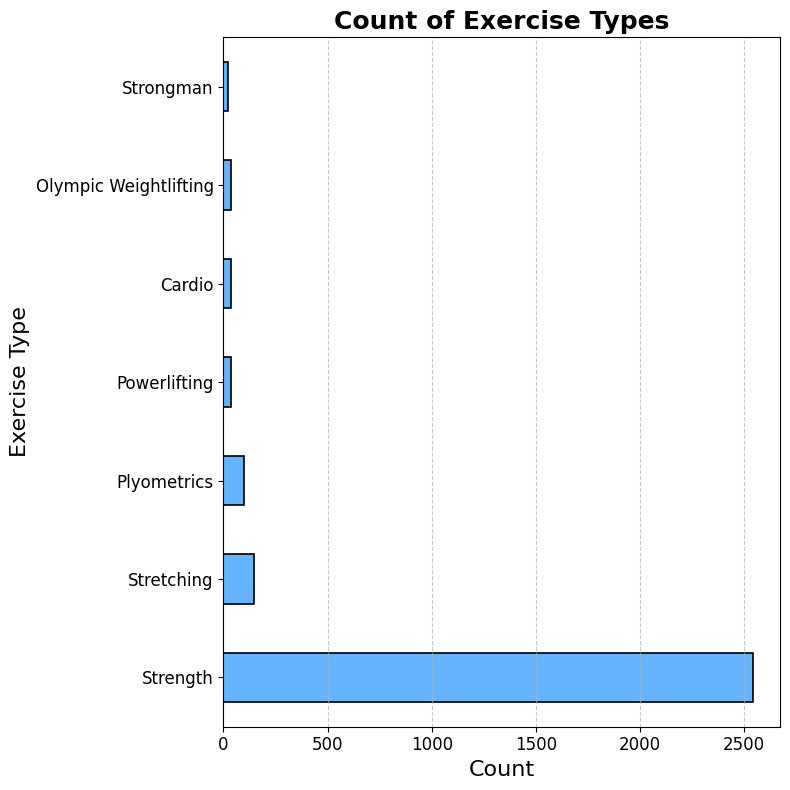

In [24]:
# Bar chart for "Count of Equipment Used"
plt.figure(figsize=figsize)
df['Type'].value_counts().plot.barh(color=bar_color, edgecolor=edge_color, linewidth=linewidth)
plt.title('Count of Exercise Types', fontsize=title_fontsize, fontweight='bold')
plt.xlabel('Count', fontsize=label_fontsize)
plt.ylabel('Exercise Type', fontsize=label_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(**grid_style)
plt.tight_layout()
plt.show()

## Understanding who this data is for
From looking at our dataset, we see that it is more geared for those who are interested in strength training and not as helpful for those who are interested in cardio because there are far less options to recommend in that category.

In [25]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def clean_text(text):
    if pd.isna(text):
        return ""
    return str(text)

def embed_text(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling
    return embeddings

def recommend_exercises(level, body_part, training_type, equipment, df, top_n=5):
    # Filter exercises by body part, making sure to prioritize body part over anything else
    filtered_exercises = df[df['BodyPart'].str.lower() == body_part.lower()].copy()

    if filtered_exercises.empty:
        filtered_exercises = df.copy()

    # Prepare text for BERT embeddings
    filtered_exercises['CombinedText'] = (
        filtered_exercises['Title'].apply(clean_text) + ' ' +
        filtered_exercises['Type'].apply(clean_text) + ' ' +
        filtered_exercises['Level'].apply(clean_text) + ' ' +
        filtered_exercises['BodyPart'].apply(clean_text) + ' ' +
        filtered_exercises['Equipment'].apply(clean_text)
    )

    # Get embeddings for exercises
    exercise_embeddings = torch.vstack([embed_text(text) for text in filtered_exercises['CombinedText']])

    # Combine user preferences into a query
    user_query = f"{level} {body_part} {training_type} {equipment}"
    query_embedding = embed_text(user_query)

    # Calculate cosine similarity between the user query and exercises
    cosine_sim = cosine_similarity(query_embedding.detach().numpy(), exercise_embeddings.detach().numpy()).flatten()

    # Add similarity scores to the dataframe
    filtered_exercises['Similarity'] = cosine_sim

    # Sort by similarity score
    sorted_exercises = filtered_exercises.sort_values('Similarity', ascending=False)

    # Get top exercises including the 'Desc' (description) column
    top_exercises = sorted_exercises[['Title', 'Type', 'Level', 'BodyPart', 'Equipment', 'Desc', 'Similarity']].head(top_n)

    # Check if any of the top exercises use the preferred equipment
    has_preferred_equipment = any(top_exercises['Equipment'].str.contains(equipment, case=False, na=False))

    return top_exercises, has_preferred_equipment

def get_user_input():
    user_level = input("Enter your level (Beginner, Intermediate, Expert): ").strip()
    user_body_part = input("Enter the body part you want to train (e.g., Abdominals, Legs, Arms): ").strip()
    user_training_type = input("Enter the type of training (Strength, Cardio, Powerlifting, Stretching): ").strip()
    user_equipment = input("Do you have a preference for equipment? (e.g., Dumbbell, Barbell, Body Only): ").strip()

    return user_level, user_body_part, user_training_type, user_equipment

def main():
    print("Welcome to the BERT Enhanced Exercise Recommender System!")


    # Ask the user for their input
    level, body_part, training_type, equipment = get_user_input()

    try:
        recommended_exercises, has_preferred_equipment = recommend_exercises(level, body_part, training_type, equipment, df)

        if recommended_exercises.empty:
            print(f"No exercises found for Body Part: {body_part}")
        else:
            print("\nTop 5 Exercises Based on Your Preferences:")
            for _, exercise in recommended_exercises.iterrows():
                print(f"\nTitle: {exercise['Title']}")
                print(f"Type: {exercise['Type']}")
                print(f"Level: {exercise['Level']}")
                print(f"Body Part: {exercise['BodyPart']}")
                print(f"Equipment: {exercise['Equipment']}")
                print(f"Description: {exercise['Desc']}")  # Display the exercise description
                print(f"Similarity Score: {exercise['Similarity']:.2f}")
                print("-" * 50)

            if not has_preferred_equipment:
                print(f"\nNote: None of the top recommendations use {equipment}.")

            print("\nExplanation of recommendations:")
            print(f"- Recommendations prioritize exercises targeting the {body_part}.")
            print("- We used BERT to match exercise attributes with your preferences.")
            print("- The recommendations are sorted by similarity to your preferences.")

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        print("Please check your input data and make sure all required columns are present and properly formatted.")

if __name__ == "__main__":
    main()



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Welcome to the BERT Enhanced Exercise Recommender System!
Enter your level (Beginner, Intermediate, Expert): Intermediate
Enter the body part you want to train (e.g., Abdominals, Legs, Arms): Abdominals
Enter the type of training (Strength, Cardio, Powerlifting, Stretching): Strength
Do you have a preference for equipment? (e.g., Dumbbell, Barbell, Body Only): Body Only

Top 5 Exercises Based on Your Preferences:

Title: Side Bridge
Type: Strength
Level: Intermediate
Body Part: Abdominals
Equipment: Body Only
Description: The side plank is a popular isometric abdominal exercise focusing on the oblique muscles, as well as the transversus abdominis or deep core muscles. It is sometimes paired with the curl up and bird dog as the “McGill big three” for core strength and stability. It is performed for time and can work in a warm-up or in the core-focused portion of any workout.
Similarity Score: 0.95
--------------------------------------------------

Title: Reach crunch
Type: Strength
Lev

We considered removing exercises that did not have a rating but decided to leave them in so there can be more exercises that are suggested to the user. This is useful because it shows the user that we are uncertain about the usefulness of the exercise, but they are still given the suggestion if they want to try it for themselves and can't find any other options.

## Conclusion

The fitness recommender system shows how NLP techniques can improve exercise recommendations based on user preferences. By using cosine similarity, the system effectively suggests exercises that match the user’s fitness level, target body part, and type of training. While the equipment filtering works well, there’s room to improve how it balances exercises that don’t require the preferred equipment but are still relevant. Overall, this research lays the groundwork for applying advanced machine learning models like BERT in personalized fitness apps, offering a lot of potential for future improvements and innovations.












## Answering our research question

After trying out the BERT-enhanced fitness recommender system, I was  impressed with how well it matched workouts to my preferences. For example, when I selected "Beginner," it suggested exercises that were easy to follow but still effective, giving me a solid introduction to strength training. On the other hand, when I chose more advanced options, the system recommended tougher workouts that would challenge even an experienced gym-goer.

What really stood out to me was how well the system adjusted to my fitness goals. Whether I wanted to focus on strength training or cardio, it provided a good mix of exercises that kept the workouts diverse and more enjoyable to follow along with. The variety of recommendations made it great for anyone, whether you’re a regular at the gym or just starting out.



In [28]:
def colab2pdf():

   ENABLE=True # @param {type:"boolean"}

   if ENABLE:

       import os, datetime, json, locale, pathlib, urllib, requests, werkzeug, nbformat, google, yaml, warnings

       locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

       NAME = pathlib.Path(werkzeug.utils.secure_filename(urllib.parse.unquote(requests.get(f"http://{os.environ['COLAB_JUPYTER_IP']}:{os.environ['KMP_TARGET_PORT']}/api/sessions").json()[0]["name"])))

       TEMP = pathlib.Path("/content/pdfs") / f"{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_{NAME.stem}"; TEMP.mkdir(parents=True, exist_ok=True)

       NB = [cell for cell in nbformat.reads(json.dumps(google.colab._message.blocking_request("get_ipynb", timeout_sec=30)["ipynb"]), as_version=4).cells if "--Colab2PDF" not in cell.source]

       warnings.filterwarnings('ignore', category=nbformat.validator.MissingIDFieldWarning)

       with (TEMP / f"{NAME.stem}.ipynb").open("w", encoding="utf-8") as nb_copy: nbformat.write(nbformat.v4.new_notebook(cells=NB or [nbformat.v4.new_code_cell("#")]), nb_copy)

       if not pathlib.Path("/usr/local/bin/quarto").exists():

           !wget -q "https://quarto.org/download/latest/quarto-linux-amd64.deb" -P {TEMP} && dpkg -i {TEMP}/quarto-linux-amd64.deb > /dev/null && quarto install tinytex --update-path --quiet

       with (TEMP / "config.yml").open("w", encoding="utf-8") as file: yaml.dump({'include-in-header': [{"text": r"\usepackage{fvextra}\DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines,breakanywhere,commandchars=\\\{\}}"}],'include-before-body': [{"text": r"\DefineVerbatimEnvironment{verbatim}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines}"}]}, file)

       !quarto render {TEMP}/{NAME.stem}.ipynb --metadata-file={TEMP}/config.yml --to pdf -M latex-auto-install -M margin-top=1in -M margin-bottom=1in -M margin-left=1in -M margin-right=1in --quiet

       google.colab.files.download(str(TEMP / f"{NAME.stem}.pdf"))

colab2pdf()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>